In [1]:
import pandas as pd
import glob
import numpy as np
from datetime import datetime
import math
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
#plt
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 14,6

/home/aldo_myrtaj/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#get all files and store their data into a dataframe
allFiles = glob.glob('debitnotes/*.csv')
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    log_date = datetime.strptime(file_.split("_")[1].split(".")[0], "%Y%m").date()
    df = pd.read_csv(file_,index_col=None, header=0)
    df['log_date'] = pd.to_datetime(log_date)
    list_.append(df)
debitnotes = pd.concat(list_)
debitnotes.index = debitnotes['log_date']

In [3]:
#set the date and the categorical values into their right format
date_columns = ['part_production_date','vehicle_registration_date','vehicle_registration_date','warranty_start_date', \
'repair_date','debit_date']
for i in date_columns:
    debitnotes[i] = pd.to_datetime(debitnotes[i], format='%Y-%m-%d')
categorical_values = ['part_type','part_group','part_production_plant','vehicle_type', 'vehicle_engine', 'vehicle_transmission', 'vehicle_mileage_category', 'vehicle_mis_category', 'vehicle_assembly_plant', 'vehicle_sales_region', 'failure_code']
for i in categorical_values:
    debitnotes[i] = debitnotes[i].astype('category')
debitnotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43442 entries, 2032-12-01 to 2020-07-01
Data columns (total 29 columns):
claim_id                     43442 non-null object
part_serial_number           43442 non-null object
part_type                    43442 non-null category
part_group                   43442 non-null category
production_id                43442 non-null object
part_production_plant        43442 non-null category
part_production_date         43442 non-null datetime64[ns]
vehicle_registration_date    43442 non-null datetime64[ns]
warranty_start_date          43442 non-null datetime64[ns]
repair_date                  43442 non-null datetime64[ns]
debit_date                   43442 non-null datetime64[ns]
dis                          43442 non-null int64
vin                          43442 non-null object
vehicle_type                 43442 non-null category
vehicle_sales_region         43442 non-null category
vehicle_engine               43442 non-null category
vehicle

### SUP & OEM failure logs data analysis

In [201]:
vehicle_type_produced = debitnotes.groupby(['vehicle_type']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Production[%]')
vehicle_type_produced

,vehicle_type,Production[%]
0,vt1,59.276737
1,vt2,11.141292
2,vt3,23.610791
3,vt4,5.971180


We see that 59% of the cars produced are normal cars(vt1), then we have 23.6% of the cars produced being of type SUV(vt1), 11.1% of them being city cruisers(vt2) and then at last place with 5.9% of the produced cars being that of sport-cars(vt4).

In [202]:
vehicle_region_sales = debitnotes.groupby(['vehicle_type', 'vehicle_sales_region']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_region_sales.pivot(index='vehicle_type', columns='vehicle_sales_region', values='Values')

vehicle_sales_region,BR,CN,DE,EU,US
vehicle_type,,,,,
vt1,6.311864,6.044841,5.816951,35.210165,5.892915
vt2,0.441969,6.868929,0.626122,2.016482,1.187791
vt3,5.752498,1.252244,1.153262,3.779752,11.673035
vt4,NaN,1.137148,1.528475,1.505456,1.800101


It is interesting to see that we have no sales of sport-cars(vt4) in Great Britain. OEMs main market is the EU one where 35% of the cars type car(vt1) are sold and then on second place comes US with around 11% of the cars being sold of type SUV(vt3). In third place we have China with its most favorite type of car being the city cruiser model(vt2).

In [203]:
vehicle_engine_type = debitnotes.groupby(['vehicle_type', 'vehicle_engine']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_engine_type.pivot(index='vehicle_type', columns='vehicle_engine', values='Values')

vehicle_engine,e1,e2,e3,e4
vehicle_type,,,,
vt1,6.682473,38.409834,7.165876,7.018553
vt2,NaN,2.288108,NaN,8.853184
vt3,16.417292,2.548225,4.645274,NaN
vt4,NaN,NaN,5.358869,0.612311


Again here it is interesting to note that the most used type of engine is the second type e2 mainly used in the car model(vt1).

In [7]:
vehicle_transmission_type = debitnotes.groupby(['vehicle_type', 'vehicle_transmission']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_transmission_type.pivot(index='vehicle_type', columns='vehicle_transmission', values='Values')

vehicle_transmission,tr1,tr2
vehicle_type,,
vt1,29.416233,29.860504
vt2,2.288108,8.853184
vt3,9.539156,14.071636
vt4,5.971180,NaN


We see that the most used transmission type is that of tr1 although not by much. We note that the sports card model does not have an option to have a tr2 (logically we can say that this corresponds to automatic transmission).

In [180]:
vehicle_part_type = debitnotes.groupby(['vehicle_type', 'part_group']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_part_type.pivot(index='vehicle_type', columns='part_group', values='Values')

part_group,re,sp,sr
vehicle_type,,,
vt1,55.918236,1.215414,2.143087
vt2,11.141292,NaN,NaN
vt3,20.109571,2.163805,1.337415
vt4,5.971180,NaN,NaN


Here we see that the regular window lifting systems are fitted in all the types of the cars and this is the main group of parts that is sold by SUP with over 90% of parts requested by OEM being regular window lifting systems. Then we have the sliding roof window system(wlssr01) that comes fitted only in a normal car(vt1) or an SUV(vt3). 
The special window lifting system and the sliding roof window system are then requested less by OEM with both having similar demand requests.

In [9]:
vehicle_type_part = debitnotes.groupby(['vehicle_type', 'part_type']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_type_part.pivot(index='part_type', columns='vehicle_type', values='Values')

vehicle_type,vt1,vt2,vt3,vt4
part_type,,,,
wlsre01l,27.959118,5.570646,10.054786,2.98559
wlsre01r,27.959118,5.570646,10.054786,2.98559
wlssp01l,0.607707,NaN,1.081902,NaN
wlssp01r,0.607707,NaN,1.081902,NaN
wlssr01,2.143087,NaN,1.337415,NaN


This is the most interestig table because here we see the distribution of the fitted parts in different types of cars. We know that the normal car(vt1) has 4(2l+2r) regular fitted window lifting systems left and right(wlsre01l wlsre01r) and as well 4(2l+2r) special window system left and right(wlssp01l wlssp01r). Although from the data (and logically) we can undertand that either one pair of normal window lifting systems is fitted or the other. City cruisers(vt2) have only 2 regular type windows(wlsre01l wlsre01r) and the same trend follows for sports-cars(vt4), while as stated above the normal car type(vt1) and SUV(vt3) have 4 window lifting system fitted and they can be either special or normal lifting systems.

In [11]:
vehicle_failure_type = debitnotes.groupby(['vehicle_type', 'failure_code']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_failure_type.pivot(index='vehicle_type', columns='failure_code', values='Values')

failure_code,f0001,f0002,f0003,f0004,f0005
vehicle_type,,,,,
vt1,23.129690,11.541826,7.333916,8.609180,8.662124
vt2,2.223655,2.410110,1.965840,2.202937,2.338751
vt3,3.618618,4.023756,3.317066,6.205976,6.445375
vt4,1.295981,1.111827,0.890843,1.319000,1.353529


It is interesting for us to know more why the parts have failed, luckily we have some error codes for each of our failed parts in each vehicle type. We see that in a normal car(vt1) the main fault with 23% of the cases is noise(f0001) and the second most common failure with 11.5% is the material break(f0002). 
The city cruiser(vt2) type of car parts have a similar failure distribution and not by much we have the most common failures happening from material break(f0002)
The SUV(vt3) type of car parts fail mostly because of an electric failure(f0004) or moslty because of unknown(f0005) reasons. 
The sports-car(vt4) type of car parts fail mostly because of unknown(f0005) with similar likelyhood of the rest of the error codes. 

In [12]:
vehicle_failure_region = debitnotes.groupby(['vehicle_sales_region', 'failure_code']).size().transform(lambda x: (x/sum(x))*100).reset_index(name='Values')
vehicle_failure_region.pivot(index='vehicle_sales_region', columns='failure_code', values='Values')

failure_code,f0001,f0002,f0003,f0004,f0005
vehicle_sales_region,,,,,
BR,3.616316,2.200635,2.138483,2.295014,2.255881
CN,4.237834,2.856682,2.732379,2.684038,2.792229
DE,4.739653,1.077298,1.086506,1.084204,1.137148
EU,14.359376,11.079140,5.816951,5.570646,5.685742
US,3.314765,1.873763,1.733346,6.703190,6.928779


If we categorize the error codes by region we see that in Great Britain the major failure is caused by noise(f0001). The same trend follows for China, Germany and Europe, while in US most failures come from an unknown reason(f0005) or electric failure(f0004). This confirms that SUVs(vt3) are sold moslty in US and that is why the failures that come from that region are similar to the failures reported by the SUV cars in general.

## Corelation between different part groups

Let us now plot and see how parts failed during time.

##### Note: We here do not take into account the production dates, we just analyze the failure dates.

In [13]:
#helper function to help us plot the time series data
def plot_time_series(data):
    plt.figure(figsize=(10, 8))
    colors = ['b-','r-','g-','c-','m-']
    for i, part_type_name in enumerate(data.columns):
        plt.plot(data[part_type_name], colors[i])
    plt.legend(); plt.xlabel('Month'); plt.ylabel('Parts x repair')
    plt.title('Failure of parts in time');
    plt.show()

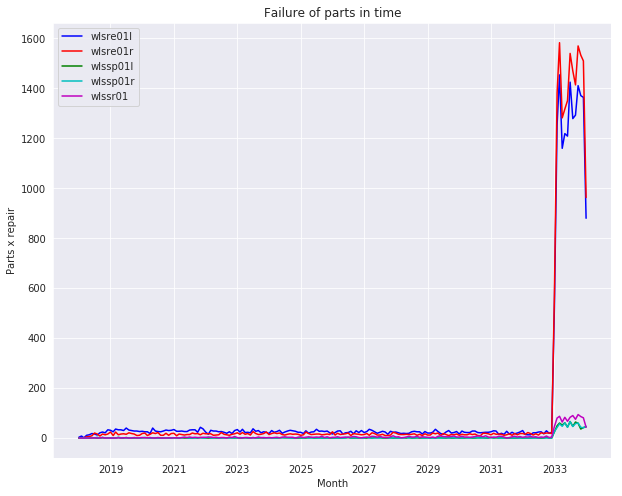

In [14]:
plotdata = debitnotes.groupby(['log_date','part_type']).size().reset_index(name='Parts')
plotdata.index = plotdata['log_date']
new_data = plotdata.pivot(index='log_date', columns='part_type', values='Parts')
new_data = new_data.fillna(0)
plot_time_series(new_data)

We can see from the graph that we have some corelation of how different parts broke down in the time series, we now take a deeper look at these corelations:

In [15]:
from scipy.stats import ttest_ind
from math import sqrt
from scipy.stats import t
#check difference of the two groups using the t-test 
#the t test (also called Student’s T Test) compares two averages (means) 
#and tells you if they are different from each other. The t test also 
#tells you how significant the differences are; In other words it lets 
#you know if those differences could have happened by chance
#The t score is a ratio between the difference between two groups and 
#the difference within the groups. The larger the t score, the more 
#difference there is between groups. The smaller the t score, the more
#similarity there is between groups
def get_group_analysis(a,b):
    ind_t_test = ttest_ind(a, b)
    print('The results of the independent t-test are: \n\tt-value = {:4.3f}\n\tp-value = {:4.3f}'.format(ind_t_test[0],ind_t_test[1]))
    mean_a = a.mean()
    mean_b = b.mean()
    diff_mean = mean_a - mean_b
    #calculating the 95% confidence interval of this difference using the marging of error
    N1 = a.count()
    N2 = b.count()
    df = (N1 + N2 - 2)
    #calculating t_val using the percent point function
    t_val = t.ppf([0.975], df)
    std_a = a.std()
    std_b = b.std()
    std_N1N2 = sqrt(((N1 - 1)*(std_a)**2 + (N2 - 1)*(std_b)**2) / df) 
    MoE = t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)
    print ('\nThe difference between groups is {:3.1f} [{:3.1f} to {:3.1f}] (mean [95% CI])'.format(diff_mean, diff_mean - MoE, diff_mean + MoE))

In [16]:
get_group_analysis(new_data['wlsre01r'], new_data['wlsre01l'])

The results of the independent t-test are: 
	t-value = 0.000
	p-value = 1.000

The difference between groups is 0.0 [-65.0 to 65.0] (mean [95% CI])


### Interpreting Result 

The t-value (t score) tells us that the two data groups are exactly the same thus their mean should as later tested be 0. They are 100% based on p-value random as the data in this dataset should be randomly generated.
This tells us that the left side of a 'regular window lifitng system' is broken during time with the same chance as the right side of a 'regular window lifting system'.

In [17]:
get_group_analysis(new_data['wlssp01l'], new_data['wlssp01r'])

The results of the independent t-test are: 
	t-value = 0.000
	p-value = 1.000

The difference between groups is 0.0 [-2.5 to 2.5] (mean [95% CI])


The same trent repeats with the special design windows lifting systems, the left side part fails with the same distribution as the right side.

In [18]:
plotdata = debitnotes.groupby(['log_date','part_group']).size().reset_index(name='Parts')
plotdata.index = plotdata['log_date']
new_data_groups = plotdata.pivot(index='log_date', columns='part_group', values='Parts')
new_data_groups = new_data_groups.fillna(0)
get_group_analysis(new_data_groups.sr, new_data_groups.sp) 

The results of the independent t-test are: 
	t-value = 0.101
	p-value = 0.920

The difference between groups is 0.2 [-4.2 to 4.7] (mean [95% CI])


From the results we see that both groupes(special window lifting systems and rooftop window lifting systems) are really similar. Their t-value is very small, and their mean difference is 0.2 with 95% of data differning from -4 to 4 parts. and the p-value is high suggesting that we can say that we have a small evidence to reject the null hypothesis, thus we accept the null hypothesis and conclude that there is no statistical difference between the two groups of parts i.e they both fail in a similar manner. 

We though choose not to model them together since they are different products and later we can find other aspects that they can differ from one another.

Let us now finally plot the failure parts per month for the 3 different groups.

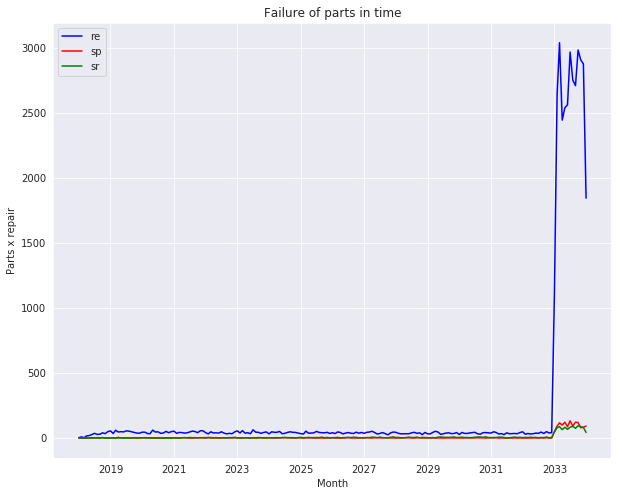

In [19]:
#comments about failed path chosen, I never dealt with such data thus it was interesting and challenging
#all these failures are only for some particular parts produced in time t-n
#n being the time that they are in service, thus even if we fit a SARIMAX model to this data 
#will not give us any interesting predictions (all parts that were created died)
plot_time_series(new_data_groups)

### Observations

The reason why the number of failures is greater in the regular window lifting system is because this kind of lifting system is fitted to all the cars. car(4) city cruiser(2) suv(4) sports car(2) thus it is logical that it will fail more through time and as well is the most requested product of SUP and it is fitted to more than 90% of the cars produced by OEM as shown above.

Even though not really clear from the graphs above the sliding roof failures are indeed similar to special windows lifting system parts, but we will see that taking into account days in service for each part these parts are not really similar in how they fail.


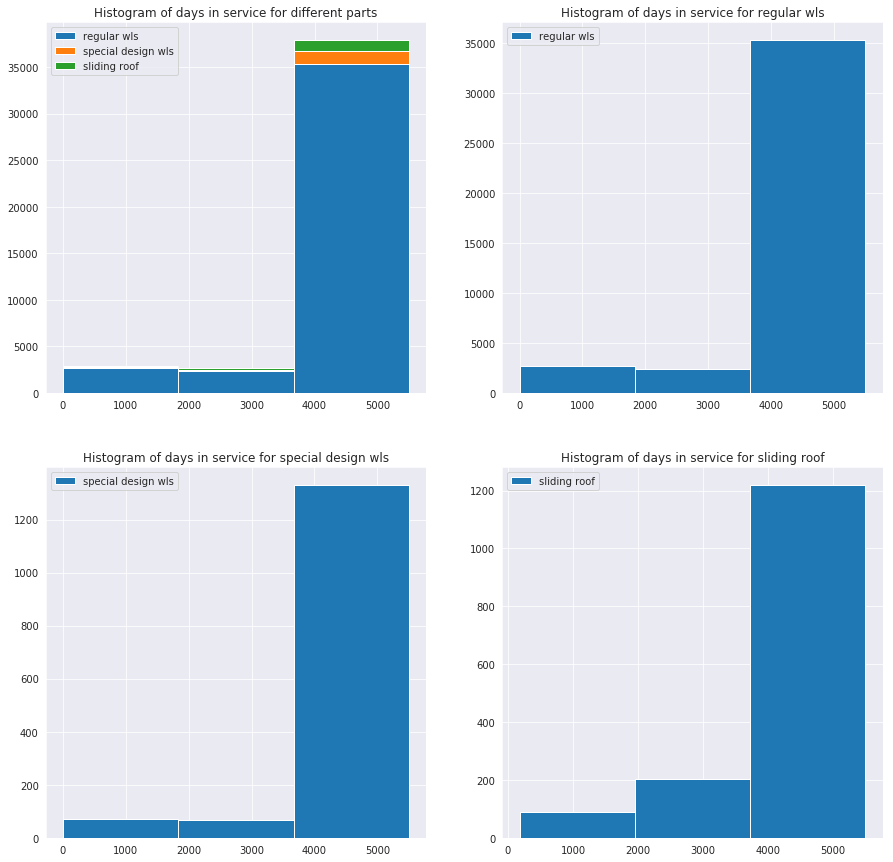

In [195]:
#ploting histograms for different parts
list1 = list()
mylabels = list()
for part in debitnotes.part_group.cat.categories:
    list1.append(debitnotes[debitnotes.part_group == part].dis)
    mylabels.append(part)
f, ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].hist(list1, bins=3, stacked=True, label=['regular wls','special design wls', 'sliding roof'])
ax[0,0].legend()
ax[0,0].set_title('Histogram of days in service for different parts')
ax[0,1].hist(list1[0], bins=3, stacked=True, label=['regular wls'])
ax[0,1].legend()
ax[0,1].set_title('Histogram of days in service for regular wls')
ax[1,0].hist(list1[1], bins=3, stacked=True, label=['special design wls'])
ax[1,0].legend()
ax[1,0].set_title('Histogram of days in service for special design wls')
ax[1,1].hist(list1[2], bins=3, stacked=True, label=['sliding roof'])
ax[1,1].legend()
ax[1,1].set_title('Histogram of days in service for sliding roof')
plt.show()

Here we have a first look at days in service for all three part groups and later we separate them to better see what we can observe from the histograms. We can see that we have more than 35000 parts that are of type regular lifting system and they fail around 2500 the first ~2000 days then the same story(although a little bit less) repeats in the second bin(2000-4000days) and then all parts die eventually in the 3rd bin. The same pattern repeats as well for the special design wls, and it makes sense since they are basically the same product (we later should compare in more detail if being special makes them more durable). In the sliding roof window system we see that these parts fail more than the first 2 given that in the second bin we see an increasing number of failures different from the first two. We can conclude from here that the sliding roof system has a higher chance to break through time than the other two parts, although we will see more in detail how later. 

### Other interesting plots to better understand the data

Let us now look at different distributions of the days in service vs some categorical data for each car the parts were fitted in.

In [21]:
#helper function that plots violin plots for different categorical data
def plot_categorical_values_vs_dis(category):
    f, ax = plt.subplots(3,figsize=(15,15), sharey=True)
    v1 = sns.violinplot(data=debitnotes[debitnotes.part_group=='re'], x=category, y="dis",ax=ax[0])
    ax[0].set_title("Regular Windows Lifting System")
    v2 = sns.violinplot(data=debitnotes[debitnotes.part_group=='sp'], x=category, y="dis",ax=ax[1])
    ax[1].set_title("Special Design Windows Lifting System")
    v3 = sns.violinplot(data=debitnotes[debitnotes.part_group=='sr'], x=category, y="dis",ax=ax[2])
    ax[2].set_title("Slididng Roof System")
    plt.show()

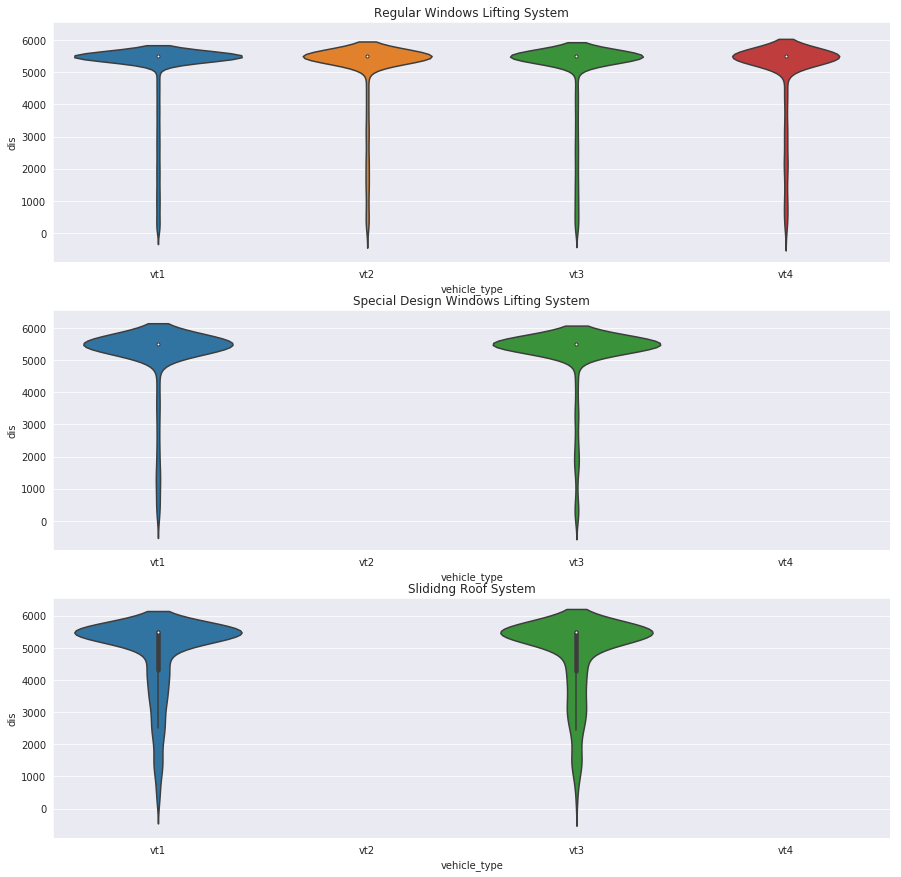

In [22]:
plot_categorical_values_vs_dis("vehicle_type")

#### Different vehicle types
We can see from these graphs that the vehicle type cannot be modeled as a variable that will affect the ouput i.e the prediction of the data since if we closely see the violin plots per part they have similar shapes.

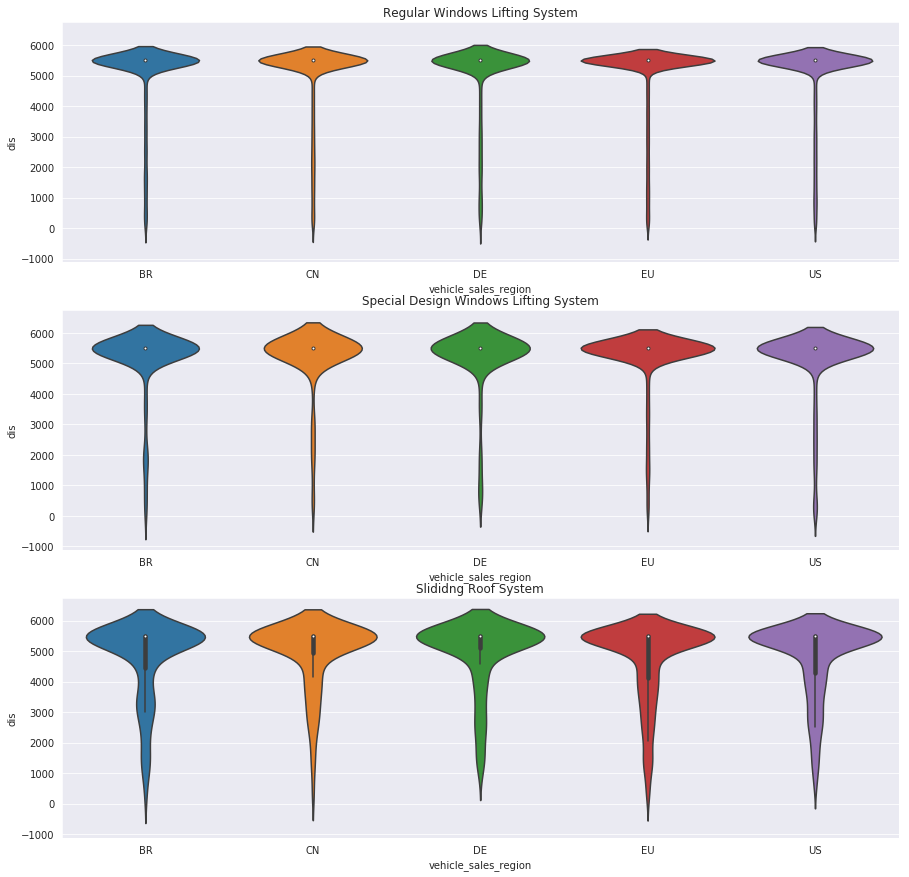

In [23]:
plot_categorical_values_vs_dis("vehicle_sales_region")

#### Different sales regions
The same realizations as above apply to the current graph. We can see that for each different part the market that the cars were sold does not really affect their failure except DE that is sligly less lengthy meaning that it has a different distribution and can affect the prediction for sliding roof tops.

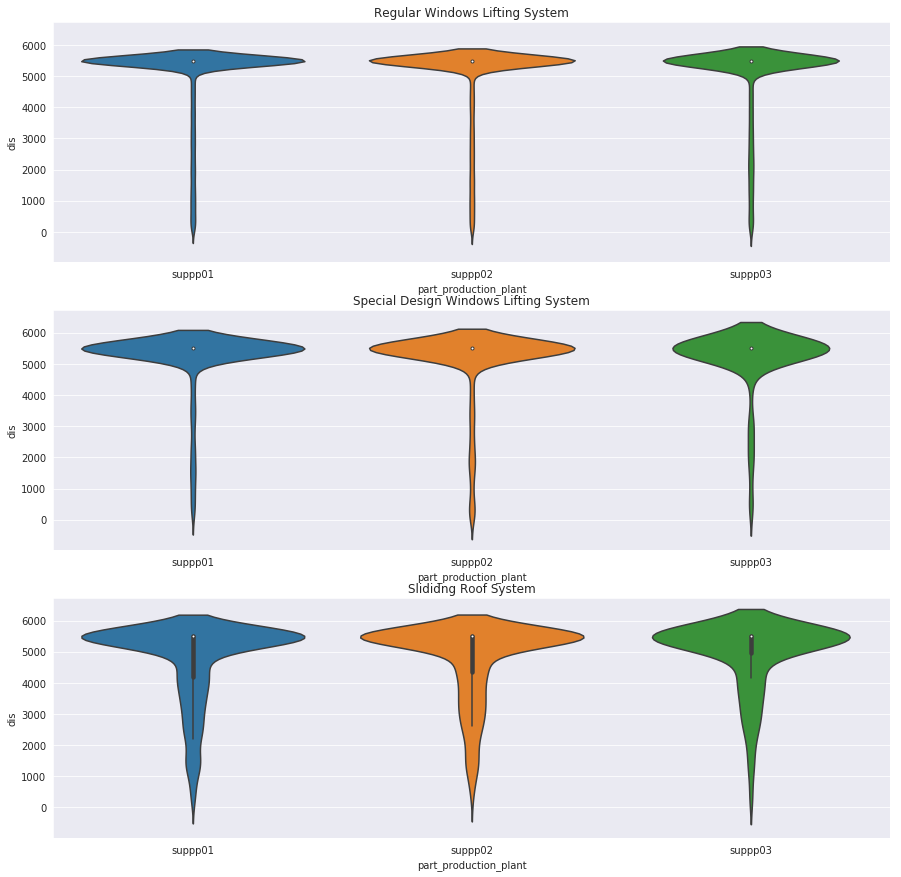

In [196]:
plot_categorical_values_vs_dis("part_production_plant")

#### Different production plants

Production plants might well affect the failure of a particular type, we can see that in the second plot the third plant has a different distribution than the first and the second plant, this categorical value will be considered as well for prediction.

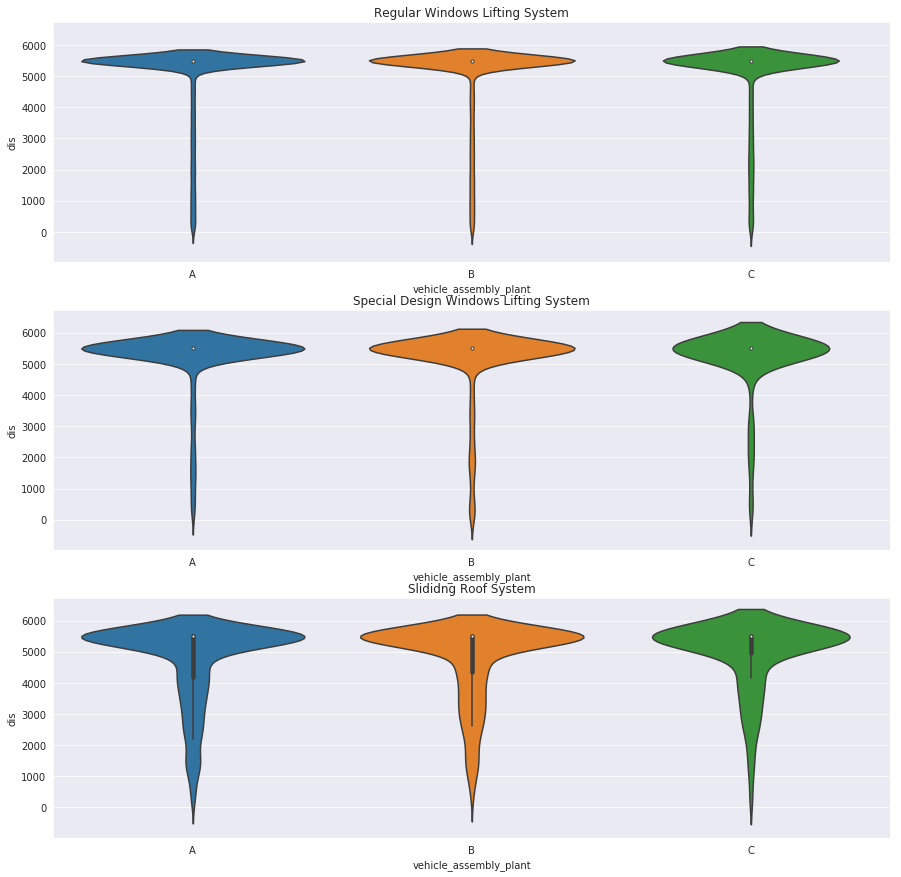

In [25]:
plot_categorical_values_vs_dis("vehicle_assembly_plant")

#### Different assembly plants

Although there are no significant changes between the distributions we will know for sure later when we test if this categorical value if interesting for prediction. We can say though that this variable wont be really predictive.

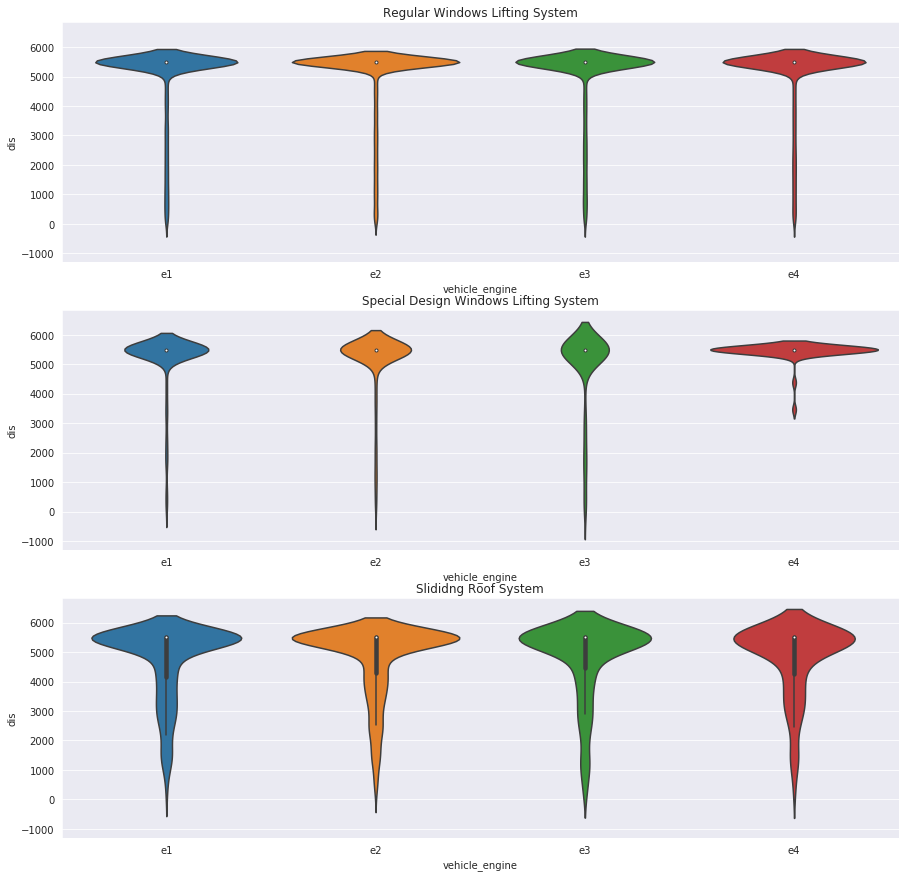

In [26]:
plot_categorical_values_vs_dis("vehicle_engine")

#### Different vehicle engines

We see that this categorical value can be significant in the prediction as well since there are some noticeble changes betwen the distributions of the violin plots especially for engine type 4 for the spectial design wls comparing to the rest.

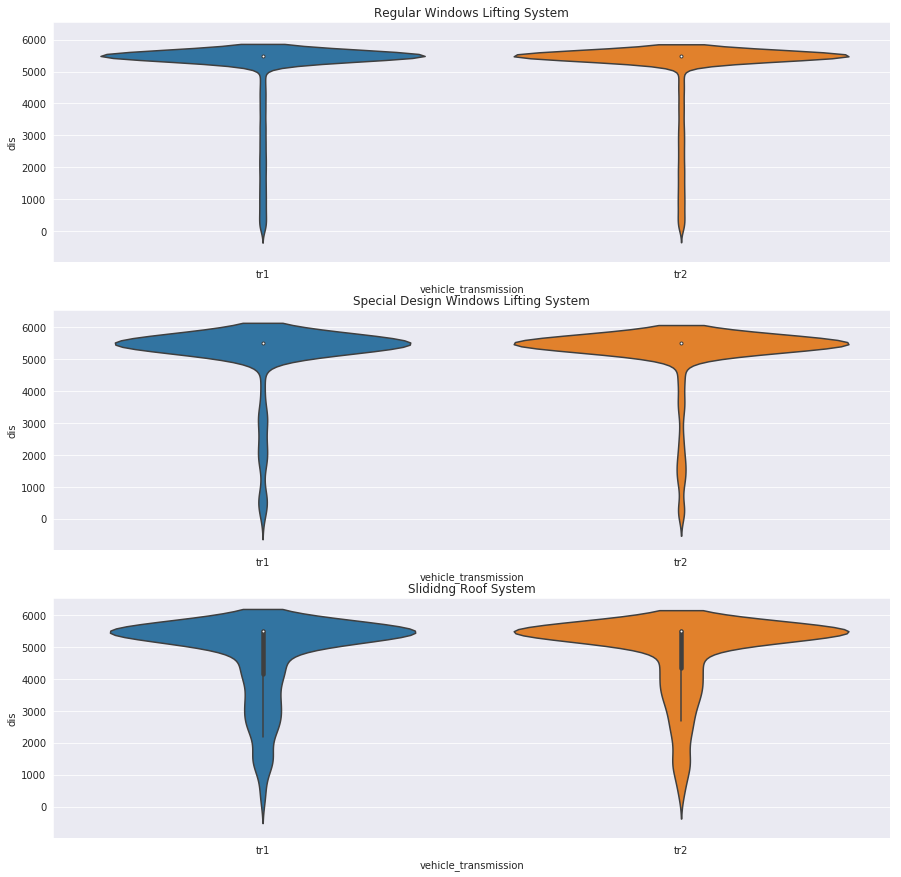

In [152]:
plot_categorical_values_vs_dis("vehicle_transmission")

#### Different vehicle transitions

We can see that the transmition of the vehicle wont really affect the failure of the three different parts since the violin plots of the two different transmittions are very similar for both sytems

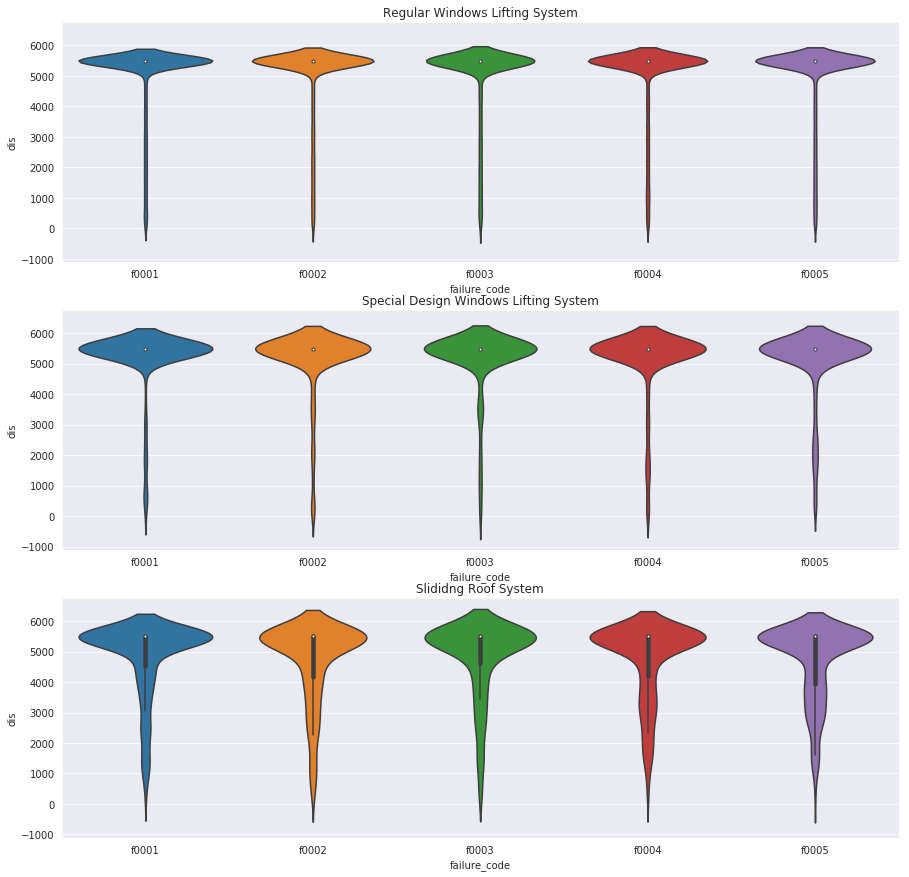

In [199]:
plot_categorical_values_vs_dis("failure_code")

#### Different failure causes

Different failure codes are reported about the way different parts fail, and here we see that no matter what code it wont really affect that much in the failures of the parts (they will fail in an almost similar way) 

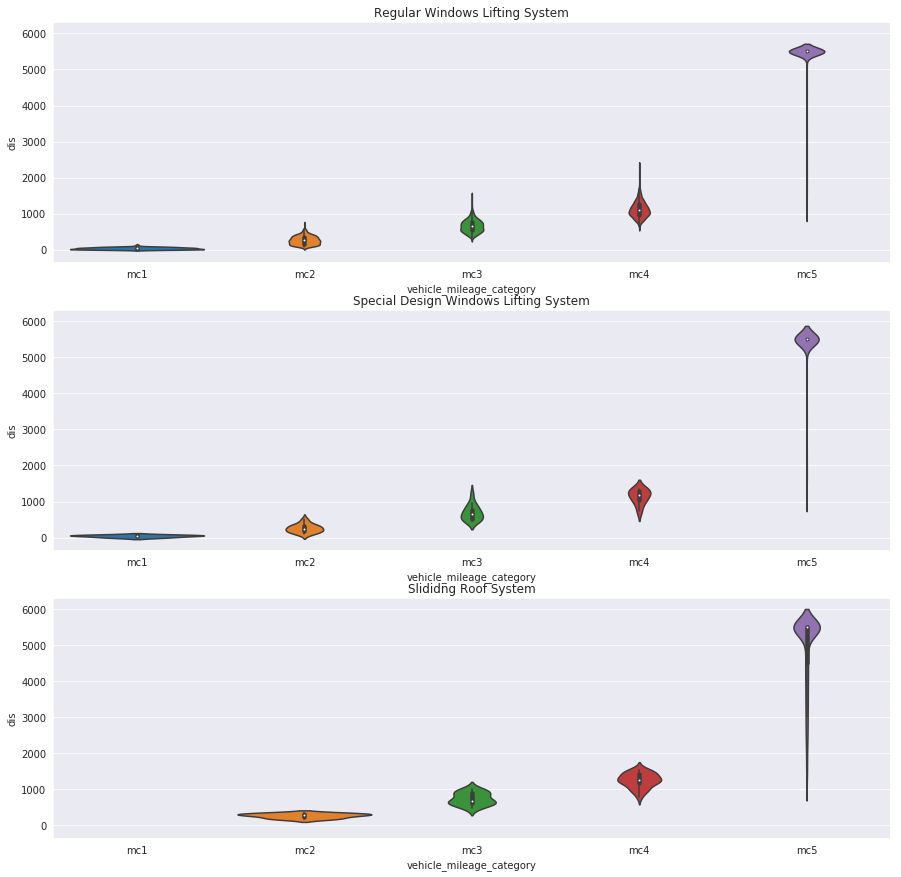

In [200]:
plot_categorical_values_vs_dis("vehicle_mileage_category")

#### Different mileage category
Finally we found a variable that can predict days in service. In all 3 graphs we see that an increase in the mileage category has a change(increase) in the mean of the days in service. Thus we can predict a parts failure rate if we know what how many miles has a car traveled.

### Analysis of Break Points

There is a spike in the data and I have a hint of what it might be, although let us first see where does this breakpoint happen and later analyze what are its factors

Num segments: 2


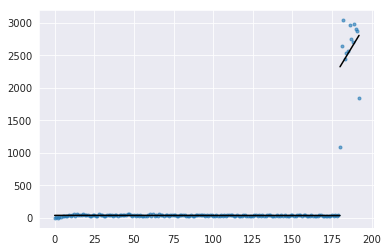

In [29]:
from piecewise.plotter import plot_data_with_regression
plot_data_with_regression(new_data_groups.reset_index(drop=True).index, new_data_groups.re.as_matrix())

Num segments: 2


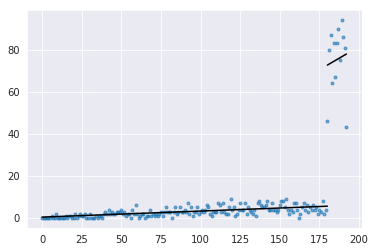

In [30]:
from piecewise.plotter import plot_data_with_regression
plot_data_with_regression(new_data_groups.reset_index(drop=True).index, new_data_groups.sr.as_matrix())

Num segments: 2


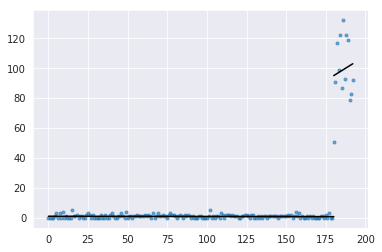

In [31]:
from piecewise.plotter import plot_data_with_regression
plot_data_with_regression(new_data_groups.reset_index(drop=True).index, new_data_groups.sp.as_matrix())

In [32]:
from piecewise.regressor import piecewise
model_wlsre01 = piecewise(new_data_groups.reset_index(drop=True).index, new_data_groups.re.as_matrix())
model_wlssp01 = piecewise(new_data_groups.reset_index(drop=True).index, new_data_groups.sr.as_matrix())
model_wlssr01 = piecewise(new_data_groups.reset_index(drop=True).index, new_data_groups.sp.as_matrix())
print(model_wlsre01)
print(model_wlssp01)
print(model_wlssr01)

FittedModel with segments:
* FittedSegment(start_t=0, end_t=180, coeffs=(40.96734192756291, -0.014843050711441595))
* FittedSegment(start_t=180, end_t=192, coeffs=(-4901.934065933964, 40.137362637362095))
FittedModel with segments:
* FittedSegment(start_t=0, end_t=180, coeffs=(0.37777777777777777, 0.028864059590316574))
* FittedSegment(start_t=180, end_t=192, coeffs=(-6.450549450546924, 0.4395604395604261))
FittedModel with segments:
* FittedSegment(start_t=0, end_t=180, coeffs=(1.1310620012277466, -0.0014023066555552092))
* FittedSegment(start_t=180, end_t=192, coeffs=(-23.637362637358702, 0.6593406593406385))


#### Interpreting results
All three of our fitted segments state that we have a breakpoint at t=180. Now we calculate what month t=180 corresponds to (we changed the index to fit the data type input of the model calculation function)

In [33]:
print("t=180 concerts to:", new_data.index[180])

t=180 concerts to: 2033-01-01 00:00:00


### Survival Analysis

Let us first neglect this break point and try to predict the numner of future failure parts using the Kaplan Meier Model.

In [205]:
#nr of parts changed during service per different vehicle type 
vehicle_parts_changed_x_service = debitnotes[['part_group','part_production_date','repair_date','vehicle_registration_date','vehicle_type', 'vin','dis','failure_code']]
#since no parts are alive we can plot all but the right-censorship
#there is no right-censorship for the data as well
vehicle_parts_changed_x_service['broken'] = 1
vehicle_parts_changed_x_service.head()

,part_group,part_production_date,repair_date,vehicle_registration_date,vehicle_type,vin,dis,failure_code,broken
log_date,,,,,,,,,
2032-12-01,re,2018-01-04,2032-12-31,2018-01-24,vt1,dsavt1e29JDaf9912,5455,f0002,1
2032-12-01,sr,2017-12-20,2032-12-16,2018-01-10,vt1,dsavt1e49JEf9cb81,5454,f0004,1
2032-12-01,sr,2017-12-14,2032-12-22,2018-01-02,vt3,dsavt3e39JU6f3a55,5468,f0002,1
2032-12-01,re,2018-02-04,2032-12-21,2018-02-26,vt3,dsavt3e19JBa1cdb4,5412,f0002,1
2032-12-01,re,2018-02-02,2032-12-06,2018-02-26,vt1,dsavt1e19JE4572aa,5397,f0005,1


In [206]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
#fitting the keplan Meier Moddel to our data
# we convers days to years
kmf.fit(durations = np.floor(vehicle_parts_changed_x_service.dis/365.5), 
        event_observed = vehicle_parts_changed_x_service.broken)
kmf.event_table.head()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,607,607,0,43442,43442
1.0,554,554,0,0,42835
2.0,580,580,0,0,42281
3.0,559,559,0,0,41701
4.0,550,550,0,0,41142


This table contains all the data needed from the model to make predictions, although here we see that we have no censored data as we stated above since all the parts have died already.

In [207]:
# get the values for time = 0 from the survival table
event_at_0 = kmf.event_table.iloc[0, :]
# now we calculate the survival probability for t = 0
surv_for_0 =  (event_at_0.at_risk - event_at_0.observed) / event_at_0.at_risk
surv_for_0

0.9860273468072372

Survival Probability S0 for the first year (i.e t = 0). We see that more than 98.60% percent of parts survive.

In [208]:
# Calculate the survival probability for t = 1
event_at_1 = kmf.event_table.iloc[1, :]
surv_for_1 =  (event_at_1.at_risk - event_at_1.observed) / event_at_1.at_risk
surv_for_1

0.9870666511030699

The value of S1 represents the conditional probability that if the parts did not fail at t=0 (immedeately), then the part has 98.70% chance of surviving the first year.

In [209]:
# Calculate the survival probability for t = 2
event_at_2 = kmf.event_table.iloc[2, :]
surv_for_2 =  (event_at_2.at_risk - event_at_2.observed) / event_at_2.at_risk
surv_for_2

0.9862822544405289

The value of S2 as well represents the conditional probability that if the parts did not fail at t=1 (after the first year), then the part has 98.62% chance of surviving the second year.

In [210]:
# The probability that a Part survives for more than 2 years
surv_after_2 = surv_for_0 * surv_for_1 * surv_for_2
surv_after_2

0.959923576262603

The joint probability that the part survives part t=0, t=1 and t=2 is about 95.99% 

In [211]:
#function in the library that does the calculations above for us
kmf.predict(5)

0.9215505731780309

The joint probability that the part will survive 5 years is 92.15%

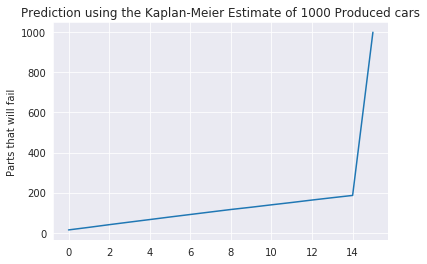

In [212]:
plt.plot((1.0 - kmf.survival_function_) * 1000)
# Add title and y-axis label
plt.title("Prediction using the Kaplan-Meier Estimate of 1000 Produced cars")
plt.ylabel("Parts that will fail")
plt.show()

Using some simple caclulations we can evaluate that we have 14 years time for less than 200 parts to fail in a 'linear' way, and then later all the parts fail in the 15th year. __We can see that the data breakpoint signifies the 'adequate' time for a part to live after that they all break due to age.__

In [44]:
kmf.median_

15.0

The median is 15, meaning that 50% of the parts will fail in the time-frame of 15 years.

### Adding Censorship to the model to have a better prediction

We know that all parts will fail at time t thus that is not really interesting for us to see, thus we will 'take out' from data all the data after the breakpoint that we discovered earlier. That breakpoint notes the time where parts started 'dying' because their lifespan was exausted, everything will fail once, thus the deaths of the most old parts are not interesting for us. Let us now clean the data and plot the censorship to the model for a more 'precise' prediction (they are the same, just loosing the fast failures due to time)

In [213]:
#create two temporary dataframes to store the data before and after the breakpoint
temp1 =  debitnotes[:'2032-12-01']
temp1['broken'] = 1
temp2 =  debitnotes['2033-01-01':'2034-03-01']
temp2['broken'] = 0
temp2['date_of_breaks'] = pd.Timestamp('2032-12-01')
temp2['dis_minus'] = temp2['repair_date'] - temp2['date_of_breaks']
temp2 = temp2.drop('date_of_breaks', axis=1)
temp2['dis_minus'] = temp2['dis_minus'].astype('timedelta64[D]')
#substranct the days of life in 2033 and 2034
temp2['dis'] = temp2['dis'] - temp2['dis_minus']
temp2 = temp2.drop('dis_minus', axis=1)
new_dis_debitnotes = pd.concat([temp1, temp2])

In [214]:
kmf.fit(durations = np.floor(new_dis_debitnotes.dis/365.5), event_observed = new_dis_debitnotes.broken)
kmf.event_table.tail()

,removed,observed,censored,entrance,at_risk
event_at,,,,,
10.0,522,522,0,0,37919
11.0,506,506,0,0,37397
12.0,531,531,0,0,36891
13.0,3566,506,3060,0,36360
14.0,32794,261,32533,0,32794


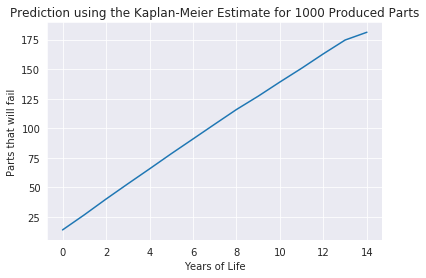

In [215]:
plt.plot((1.0 - kmf.survival_function_) * 1000)
# Add title and y-axis label
plt.title("Prediction using the Kaplan-Meier Estimate for 1000 Produced Parts")
plt.ylabel("Parts that will fail")
plt.xlabel("Years of Life")
plt.show()

As we can see from this graph in two years, approx 40 parts fail. __We can say that we will know for sure that 40/1000 or 4% of the parts produced will be broken in the warranty time and they have to be replaced for free.__

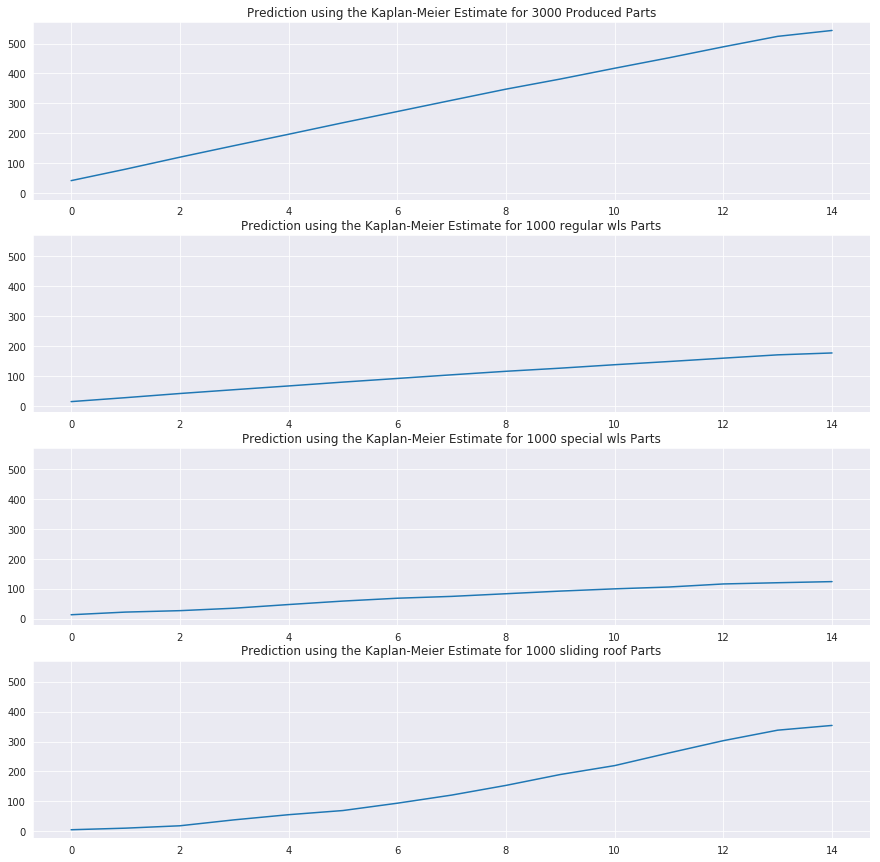

In [165]:
f, ax = plt.subplots(4,figsize=(15,15), sharey=True)
kmf.fit(durations = np.floor(new_dis_debitnotes.dis/365.5), event_observed = new_dis_debitnotes.broken)
ax[0].plot((1.0 - kmf.survival_function_) * 3000)
ax[0].set_title('Prediction using the Kaplan-Meier Estimate for 3000 Produced Parts')
kmf.fit(durations = np.floor(new_dis_debitnotes[new_dis_debitnotes.part_group=='re'].dis/365.5), event_observed = new_dis_debitnotes[new_dis_debitnotes.part_group=='re'].broken)
ax[1].plot((1.0 - kmf.survival_function_) * 1000)
ax[1].set_title('Prediction using the Kaplan-Meier Estimate for 1000 regular wls Parts')
kmf.fit(durations = np.floor(new_dis_debitnotes[new_dis_debitnotes.part_group=='sp'].dis/365.5), event_observed = new_dis_debitnotes[new_dis_debitnotes.part_group=='sp'].broken)
ax[2].plot((1.0 - kmf.survival_function_) * 1000)
ax[2].set_title('Prediction using the Kaplan-Meier Estimate for 1000 special wls Parts')
kmf.fit(durations = np.floor(new_dis_debitnotes[new_dis_debitnotes.part_group=='sr'].dis/365.5), event_observed = new_dis_debitnotes[new_dis_debitnotes.part_group=='sr'].broken)
ax[3].plot((1.0 - kmf.survival_function_) * 1000)
ax[3].set_title('Prediction using the Kaplan-Meier Estimate for 1000 sliding roof Parts')
plt.show()

As we see from this graph, the general failure of the parts is similar to that of the Regular Window Systems. Another interesitng observation is that all parts fail in a similar way in the time frame of 4 years. In 4 years in general around 110 parts fail, from these 45 are regular window lifiting systems, 35 are special window lifting system and 30 are slinding roof tops. 

After 4 years though we see that the sliding roof tops are the ones that start breaking faster, while the other two part types follow the same trend.

A more precise kaplan meier estimator can be calculated from the scikit-learn library

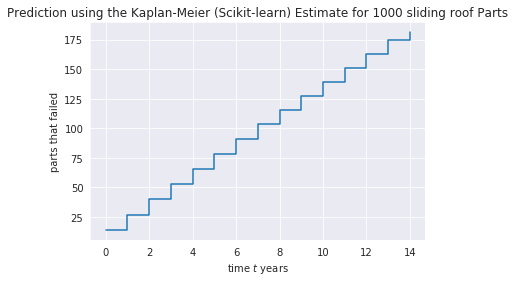

In [63]:
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(new_dis_debitnotes['broken'].astype('bool'), np.floor(new_dis_debitnotes['dis']/365.5))
plt.step(time,(1.0 - survival_prob)*1000, where="post")
plt.ylabel("parts that failed")
plt.xlabel("time $t$ years")
plt.title('Prediction using the Kaplan-Meier (Scikit-learn) Estimate for 1000 sliding roof Parts')
plt.show()

As we can see from this graph in two years, approx 25 parts fail. We can say that we will know for sure that 25/1000 or approx 3% of the parts produced will be broken in the warranty time and they have to be replaced for free. __This prediction is a little bit different from what we got above although both conclude that 3-4% of the parts will fail in 2 years__

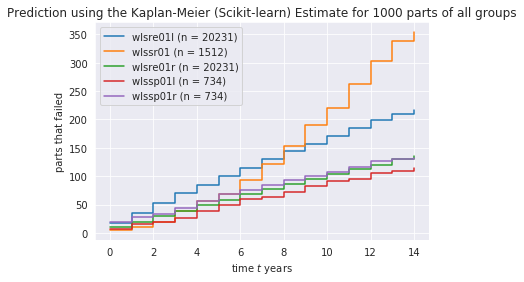

In [65]:
for value in new_dis_debitnotes["part_type"].unique():
    mask = new_dis_debitnotes["part_type"] == value
    time_part, survival_prob_part = kaplan_meier_estimator(new_dis_debitnotes['broken'][mask].astype('bool'),
                                                           np.floor(new_dis_debitnotes['dis'][mask]/365.5))
    plt.step(time_part, (1-survival_prob_part)*1000, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("parts that failed")
plt.xlabel("time $t$ years")
plt.legend(loc="best")
plt.title('Prediction using the Kaplan-Meier (Scikit-learn) Estimate for 1000 parts of all groups')
plt.show()

It is interesting that the left and right sides of the same part fail in a similar manner (notice the same slope on the lines) although it is interesting to notice how one side fails a factor of magnitude more than the other.

As we saw before the sliding window system fails at first two years with a comparable rate than the rest of the part types, although through time it increases and at 10 years around 220/1000 or 22% of the parts produced fail.

Let us see in detail what happens now to the left and right parts of both regular and special sliding windows systems.

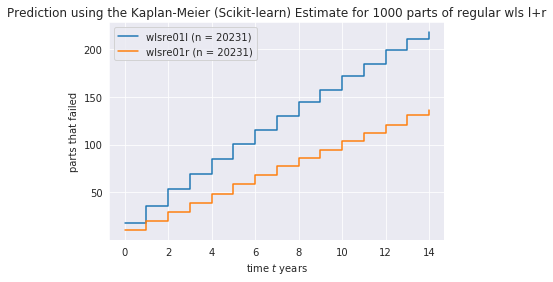

In [216]:
for value in new_dis_debitnotes[new_dis_debitnotes['part_group'] == 're'].part_type.unique():
    mask = new_dis_debitnotes.part_type == value
    time_part, survival_prob_part = kaplan_meier_estimator(new_dis_debitnotes['broken'][mask].astype('bool'),
                                                           np.floor(new_dis_debitnotes['dis'][mask]/365.5))
    plt.step(time_part, (1-survival_prob_part)*1000, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("parts that failed")
plt.xlabel("time $t$ years")
plt.legend(loc="best")
plt.title('Prediction using the Kaplan-Meier (Scikit-learn) Estimate for 1000 parts of regular wls l+r')
plt.show()

##### Regular lifting systems
We can clearly see that in two years more left windows are predicted to fail then right ones, approximately twice as much. This trend seems to follow through the graph. __The left regular window lifting systems fail more than the right regular window lifting systems.__ 

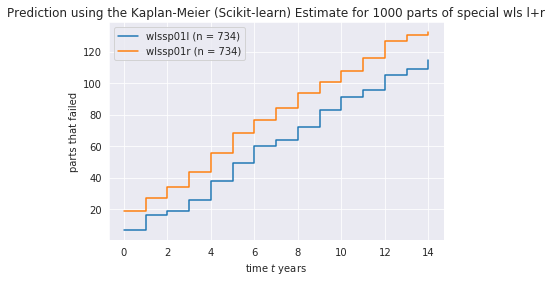

In [217]:
for value in new_dis_debitnotes[new_dis_debitnotes['part_group'] == 'sp'].part_type.unique():
    mask = new_dis_debitnotes.part_type == value
    time_part, survival_prob_part = kaplan_meier_estimator(new_dis_debitnotes['broken'][mask].astype('bool'),
                                                           np.floor(new_dis_debitnotes['dis'][mask]/365.5))
    plt.step(time_part, (1-survival_prob_part)*1000, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("parts that failed")
plt.xlabel("time $t$ years")
plt.legend(loc="best")
plt.title('Prediction using the Kaplan-Meier (Scikit-learn) Estimate for 1000 parts of special wls l+r')
plt.show()

##### Special lifting systems
In the special lifting systems both of the curves are very similar, the right part of the special wls fails the most although by not much, in years these part fail in this way: the curve of the left special wls + b(constant) = right special wls, where b here is approx 20 units. thus we can say that at time t=0 20 units more of the right part failed than the left, and then they __both fail in a very similar manner.__


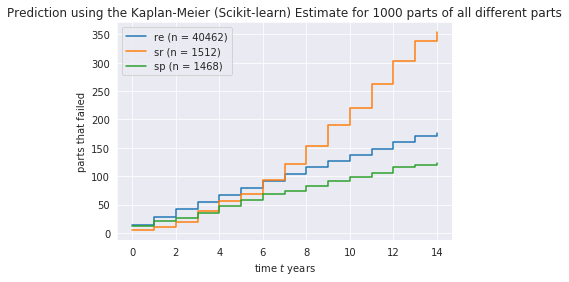

In [219]:
for value in new_dis_debitnotes.part_group.unique():
    mask = new_dis_debitnotes.part_group == value
    time_part, survival_prob_part = kaplan_meier_estimator(new_dis_debitnotes['broken'][mask].astype('bool'),
                                                           np.floor(new_dis_debitnotes['dis'][mask]/365.5))
    plt.step(time_part, (1-survival_prob_part)*1000, where="post",
             label="%s (n = %d)" % (value, mask.sum()))

plt.ylabel("parts that failed")
plt.xlabel("time $t$ years")
plt.legend(loc="best")
plt.title('Prediction using the Kaplan-Meier (Scikit-learn) Estimate for 1000 parts of all different parts')
plt.show()

##### Part group failure differences and similarities
As stated in the beginning histogram and the Kaplan Meier Model predicted by the lifelines python library, here as well __we see a similar trend of failures between the regular windows lifting systems and the special window lifting system (here less parts from the special wls fail because of its protective glass). After 6 years we see that the degradation of the sliding rooftops increases making them the most failed parts__ in our assumed 3000 parts produced(3 groups x 1000 parts).

### Survival Regression
It is interesing to know what are the factors that the parts fail. We have a lot of other categorical/nomerical values (covariates) that we can search and reach a better understanding how the parts did fail or are presumed to fail in the near future. There are two different approaches we can follow to model the prediction, we can use Cox's model or Aalen's additive model. Let us choose one and get more insights on the data

In [134]:
from sksurv.preprocessing import OneHotEncoder
data_x = new_dis_debitnotes[['part_group', 'part_production_plant',  'vehicle_type', 'vehicle_sales_region',\
       'vehicle_engine', 'vehicle_transmission', 'vehicle_assembly_plant', 'vehicle_mileage_category','failure_code', 'vehicle_mileage']]
data_x_numeric = OneHotEncoder().fit_transform(data_x)
data_x_numeric.head()

,part_group=sp,part_group=sr,part_production_plant=suppp02,part_production_plant=suppp03,vehicle_type=vt2,vehicle_type=vt3,vehicle_type=vt4,vehicle_sales_region=CN,vehicle_sales_region=DE,vehicle_sales_region=EU,...,vehicle_assembly_plant=C,vehicle_mileage_category=mc2,vehicle_mileage_category=mc3,vehicle_mileage_category=mc4,vehicle_mileage_category=mc5,failure_code=f0002,failure_code=f0003,failure_code=f0004,failure_code=f0005,vehicle_mileage
log_date,,,,,,,,,,,,,,,,,,,,,
2032-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,681875
2032-12-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,599940
2032-12-01,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,678032
2032-12-01,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,714384
2032-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,782565


In order to know the inpact of each categorical variable we have to binary encode them and as well take the baseline data to compare with others. In this case the baseline of our data will be a regualar lifting window system, produced in plant suppp01, part was fitted in a car, the car was sold in Great Britain, the vehicle assembly plant is A, vehicle engine type was e1 and transmission fitted was t1, mileage category is mc1 and failure code is f0001

In [135]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
#We fit the Cox Survival Analysis model and we set alpha to 0.001 since there are not many differences between 
#our categorical values and if we leave this variable as default we then get an error about infinite or undefined 
#variables.
estimator = CoxPHSurvivalAnalysis(alpha= 0.001)
data_y = {'broken': new_dis_debitnotes['broken'].astype('bool'), 'dis': np.floor(new_dis_debitnotes['dis']/365.5)}
data_y = pd.DataFrame(data=data_y)
def x(data):
    return [(x, y) for x, y in zip(data['broken'], data['dis'])] 
data_y = np.array(x(data_y),dtype=[('broken', bool), ('dis', float)])
estimator.fit(data_x_numeric, data_y )


CoxPHSurvivalAnalysis(alpha=0.001, n_iter=100, tol=1e-09, verbose=0)

In [136]:
pd.Series(estimator.coef_, index=data_x_numeric.columns)

part_group=sp                   -0.210849
part_group=sr                    0.371987
part_production_plant=suppp02   -0.001333
part_production_plant=suppp03    0.005643
vehicle_type=vt2                -0.080982
vehicle_type=vt3                 0.024121
vehicle_type=vt4                 0.169150
vehicle_sales_region=CN          0.005643
vehicle_sales_region=DE         -0.019705
vehicle_sales_region=EU          0.015395
vehicle_sales_region=US          0.017817
vehicle_engine=e2                0.041472
vehicle_engine=e3               -0.038405
vehicle_engine=e4                0.063728
vehicle_transmission=tr2         0.033763
vehicle_assembly_plant=B        -0.001333
vehicle_assembly_plant=C         0.005643
vehicle_mileage_category=mc2    -0.020533
vehicle_mileage_category=mc3    -0.936897
vehicle_mileage_category=mc4    -1.661536
vehicle_mileage_category=mc5    -2.243343
failure_code=f0002              -0.028839
failure_code=f0003               0.017319
failure_code=f0004              -0

We have fitted the model and these are the log hazard ratios per each categorical value, we can now use this model to predict new data values etc, although first let us check if this model is correct. 

In [137]:
estimator.score(data_x_numeric, data_y)

0.9493919771187533

The Scikit-learn library uses the Harell's concordance index as to find out how well the model can predict survival. We see from the output adove that this value is close to 1.0 (a perfect model) thus we can consider this a good fit.

### What variable is the most predictive? 

Let us now answer the question of what categorical values will be the best risk predictors. We fit the Cox model to each individual variable. 
The concordance index for each variable is displayed next to its name.

In [150]:
#approx 1h to calculate for each variable, we could exclude some from 
#the analysis we did beforehand with the violinplots although it is more precise to do this and later compare
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha= 0.001)
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
        print(((j+1)/n_features)*100 ,'% done')
    return scores

scores = fit_and_score_features(data_x_numeric.values, data_y)
pd.Series(scores, index=data_x_numeric.columns).sort_values(ascending=False)

3.8461538461538463 % done
7.6923076923076925 % done
11.538461538461538 % done
15.384615384615385 % done
19.230769230769234 % done
23.076923076923077 % done
26.923076923076923 % done
30.76923076923077 % done
34.61538461538461 % done
38.46153846153847 % done
42.30769230769231 % done
46.15384615384615 % done
50.0 % done
53.84615384615385 % done
57.692307692307686 % done
61.53846153846154 % done
65.38461538461539 % done
69.23076923076923 % done
73.07692307692307 % done
76.92307692307693 % done
80.76923076923077 % done
84.61538461538461 % done
88.46153846153845 % done
92.3076923076923 % done
96.15384615384616 % done
100.0 % done


vehicle_mileage                  0.948599
vehicle_mileage_category=mc5     0.641034
vehicle_mileage_category=mc4     0.545747
vehicle_mileage_category=mc3     0.544856
vehicle_mileage_category=mc2     0.539766
part_group=sr                    0.516319
part_group=sp                    0.505820
vehicle_type=vt2                 0.504719
vehicle_transmission=tr2         0.504313
vehicle_type=vt3                 0.504245
vehicle_engine=e4                0.504225
failure_code=f0003               0.503712
vehicle_engine=e2                0.501674
part_production_plant=suppp02    0.501390
vehicle_assembly_plant=B         0.501390
vehicle_sales_region=US          0.501224
vehicle_type=vt4                 0.501126
failure_code=f0005               0.500977
vehicle_sales_region=EU          0.500957
failure_code=f0002               0.500556
failure_code=f0004               0.500425
vehicle_engine=e3                0.500410
vehicle_sales_region=CN          0.500322
part_production_plant=suppp03    0

Interperting the results:
##### Vehicle mileage & Vehicle mileage category (mc1 as baseline) 
We see clearly that the vehicle mileage affects the failure concluding __more mileage more broken windows__ 
##### Part group (regular as baseline)
The next obvious predictor will be the part group since different types of parts have different times of failure. as it was shown in the graphs above

All other categorical values do not matter much for the prediction and we as well though before when exploring the data. We can now predict using all the above values but the same model accuracy can be obtained only if we know the mileage and the vehicle part group. These two variables if given as an input to our model we can predict its lifespan. 

### Additional Work

We can the model to predict lifelines for given categorical variables, as well as we can use a decision tree thus I am not sure that branching after mileage category will give us more interesting facts if we divide by other categorical values. (I did not have time to do that due to my HiWi job and some other appointments) 

### Remarks 
I did really enjoy this challenge it made me study a lot of new things I did tacke some data and some kind of analysis that I have never done before, I did start unexperienced trying to fit an ARIMA model to the data, until I finally saw the bigger picture and used Survival Analysis and Survival Regression models to fully explain and get what was required from the data.